# Classification Workflow with Pipelines

Let's add pipelines into our workflow!

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import plot_confusion_matrix, recall_score,\
    accuracy_score, precision_score, f1_score

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImPipeline

In [2]:
titanic = pd.read_csv('data/titanic.csv')
titanic.head()

PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S

In [3]:
X = titanic.drop(['PassengerId', 'Name', 'Survived'], axis=1)
y = titanic['Survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [4]:
# Explore the data

In [5]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    891 non-null    int64  
 1   Sex       891 non-null    object 
 2   Age       714 non-null    float64
 3   SibSp     891 non-null    int64  
 4   Parch     891 non-null    int64  
 5   Ticket    891 non-null    object 
 6   Fare      891 non-null    float64
 7   Cabin     204 non-null    object 
 8   Embarked  889 non-null    object 
dtypes: float64(2), int64(3), object(4)
memory usage: 62.8+ KB


In [6]:
X.describe()

Pclass         Age       SibSp       Parch        Fare
count  891.000000  714.000000  891.000000  891.000000  891.000000
mean     2.308642   29.699118    0.523008    0.381594   32.204208
std      0.836071   14.526497    1.102743    0.806057   49.693429
min      1.000000    0.420000    0.000000    0.000000    0.000000
25%      2.000000   20.125000    0.000000    0.000000    7.910400
50%      3.000000   28.000000    0.000000    0.000000   14.454200
75%      3.000000   38.000000    1.000000    0.000000   31.000000
max      3.000000   80.000000    8.000000    6.000000  512.329200

In [7]:
X.describe(include='O')

Sex  Ticket    Cabin Embarked
count    891     891      204      889
unique     2     681      147        3
top     male  347082  B96 B98        S
freq     577       7        4      644

In [8]:
titanic.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

<AxesSubplot:xlabel='Age', ylabel='Count'>

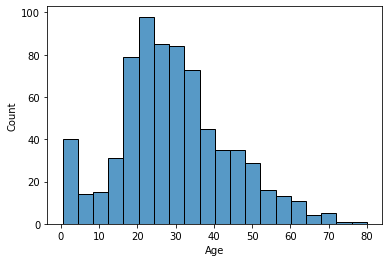

In [9]:
sns.histplot(X['Age'])

<AxesSubplot:xlabel='Fare', ylabel='Count'>

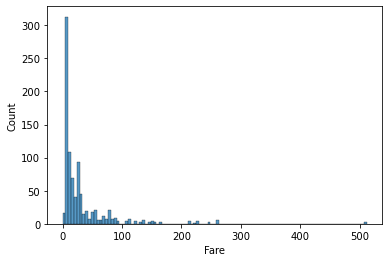

In [10]:
sns.histplot(X['Fare'])

In [11]:
X['Embarked'].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

## Using `Pipeline` and `FunctionTransformer`

Let's try a very simple pipeline first.

In [12]:
def grab_numeric(df):
    return df.select_dtypes(include=['float', 'int'])


In [13]:
# The FunctionTransformer will turn my function
# into a transformer.

GrabNumeric = FunctionTransformer(grab_numeric)

In [14]:
pipe = Pipeline(steps=[('num', GrabNumeric),
                       ('ss', StandardScaler())])

In [15]:
pipe.fit(X_train)

Pipeline(steps=[('num',
                 FunctionTransformer(func=<function grab_numeric at 0x7f92685cec10>)),
                ('ss', StandardScaler())])

In [16]:
pipe.transform(X_train)

array([[-1.62051704,         nan, -0.46765956, -0.46887833, -0.0325683 ],
       [ 0.80934914, -0.30465857, -0.46765956, -0.46887833, -0.48733085],
       [-0.40558395, -0.3735649 , -0.46765956,  2.04687047, -0.34285405],
       ...,
       [ 0.80934914,  0.79784282,  1.22097065, -0.46887833, -0.35045024],
       [-1.62051704, -1.06262827,  0.37665554,  2.04687047,  1.7030926 ],
       [-1.62051704, -0.58028391, -0.46765956,  0.78899607,  0.8747751 ]])

That looks like it worked!

## Using `Pipeline` and `ColumnTransformer`

When we use the `ColumnTransformer` we'll want to choose the relevant column numbers, so let's remind ourselves which columns are where:

In [17]:
X.head()

Pclass     Sex   Age  SibSp  Parch            Ticket     Fare Cabin  \
0       3    male  22.0      1      0         A/5 21171   7.2500   NaN   
1       1  female  38.0      1      0          PC 17599  71.2833   C85   
2       3  female  26.0      0      0  STON/O2. 3101282   7.9250   NaN   
3       1  female  35.0      1      0            113803  53.1000  C123   
4       3    male  35.0      0      0            373450   8.0500   NaN   

  Embarked  
0        S  
1        C  
2        S  
3        S  
4        S

In [18]:
# We'll throw these mini-pipelines into our ColumnTransformer.

subpipe_num = Pipeline(steps=[('num_impute', SimpleImputer()),
                           ('ss', StandardScaler())])
subpipe_cat = Pipeline(steps=[('cat_impute', SimpleImputer(strategy='most_frequent')),
                             ('ohe', OneHotEncoder(sparse=False, handle_unknown='ignore'))])

In [19]:
# The "remainder='passthrough'" bit tells the compiler to leave
# the other df columns unchanged.
#cat_cols = 
#num_cols =  

CT = ColumnTransformer(transformers=[('subpipe_num', subpipe_num, [2, 3, 4, 6]),
                                         ('subpipe_cat', subpipe_cat, [0, 1, 5, 7, 8])],
                           remainder='passthrough')

In [20]:
# The `ColumnTransformer` will take care of our preprocessing,
# so now we can add our model at the end of the pipeline.

logreg_model_pipe = Pipeline(steps=[('ct', CT),
                            ('logreg', LogisticRegression(random_state=42))])

In [21]:
logreg_model_pipe.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('subpipe_num',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer()),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  [2, 3, 4, 6]),
                                                 ('subpipe_cat',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                         

In [22]:
logreg_model_pipe.score(X_train, y_train)

0.8922155688622755

## Bringing in Our Modeling Class from before

In [23]:
class ModelWithCV():
    '''Structure to save the model and more easily see its crossvalidation'''
    
    def __init__(self, model, model_name, X, y, cv_now=True):
        self.model = model
        self.name = model_name
        self.X = X
        self.y = y
        # For CV results
        self.cv_results = None
        self.cv_mean = None
        self.cv_median = None
        self.cv_std = None
        #
        if cv_now:
            self.cross_validate()
        
    def cross_validate(self, X=None, y=None, kfolds=10):
        '''
        Perform cross-validation and return results.
        
        Args: 
          X:
            Optional; Training data to perform CV on. Otherwise use X from object
          y:
            Optional; Training data to perform CV on. Otherwise use y from object
          kfolds:
            Optional; Number of folds for CV (default is 10)  
        '''
        
        cv_X = X if X else self.X
        cv_y = y if y else self.y

        self.cv_results = cross_val_score(self.model, cv_X, cv_y, cv=kfolds)
        self.cv_mean = np.mean(self.cv_results)
        self.cv_median = np.median(self.cv_results)
        self.cv_std = np.std(self.cv_results)

        
    def print_cv_summary(self):
        cv_summary = (
        f'''CV Results for `{self.name}` model:
            {self.cv_mean:.5f} ± {self.cv_std:.5f} accuracy
        ''')
        print(cv_summary)

        
    def plot_cv(self, ax):
        '''
        Plot the cross-validation values using the array of results and given 
        Axis for plotting.
        '''
        ax.set_title(f'CV Results for `{self.name}` Model')
        # Thinner violinplot with higher bw
        sns.violinplot(y=self.cv_results, ax=ax, bw=.4)
        sns.swarmplot(
                y=self.cv_results,
                color='orange',
                size=10,
                alpha= 0.8,
                ax=ax
        )

        return ax

In [24]:
log_pipe = ModelWithCV(logreg_model_pipe, model_name='log_pipe', X=X_train, y=y_train)

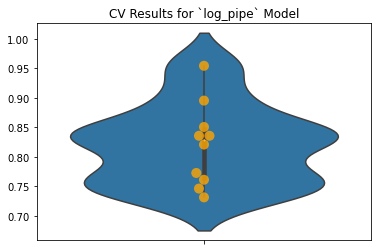

In [25]:
fig, ax = plt.subplots()

log_pipe.plot_cv(ax=ax);

In [26]:
log_pipe.print_cv_summary()

CV Results for `log_pipe` model:
            0.82049 ± 0.06651 accuracy
        


## Trying Other Models at the End of the Pipeline

Can I have multiple models in a single pipeline? Yes. We'll forgo this here, but for more on this see [here](https://stackoverflow.com/questions/48507651/multiple-classification-models-in-a-scikit-pipeline-python).

### Random Forest

In [27]:
rfc = RandomForestClassifier(random_state=42)

rfc_model_pipe = Pipeline([('ct', CT), ('rfc', rfc)])

In [28]:
rfc_model_pipe.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('subpipe_num',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer()),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  [2, 3, 4, 6]),
                                                 ('subpipe_cat',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                         

In [29]:
rfc_model_pipe.score(X_train, y_train)

0.9985029940119761

In [30]:
forest_pipe = ModelWithCV(model=rfc_model_pipe,
                          model_name='forest_pipe',
                          X=X_train,
                          y=y_train)

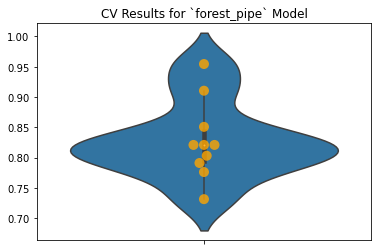

In [31]:
fig, ax = plt.subplots()

forest_pipe.plot_cv(ax=ax);

In [44]:
# Grid Searching with n_jobs
grid = {'ct__subpipe_num__num_impute__strategy': ['mean', 'median', 'mode'],
        'rfc__max_depth': [3, 5, 7], 
        'rfc__n_estimators': [50, 100],
        'rfc__min_samples_leaf': [1, 3, 5]}

gs_rfc = GridSearchCV(rfc_model_pipe, param_grid=grid, cv=5, verbose=3)

In [45]:
gs_rfc.fit(X_train, y_train)

Fitting 5 folds for each of 54 candidates, totalling 270 fits
[CV] ct__subpipe_num__num_impute__strategy=mean, rfc__max_depth=3, rfc__min_samples_leaf=1, rfc__n_estimators=50 
[CV]  ct__subpipe_num__num_impute__strategy=mean, rfc__max_depth=3, rfc__min_samples_leaf=1, rfc__n_estimators=50, score=0.739, total=   0.1s
[CV] ct__subpipe_num__num_impute__strategy=mean, rfc__max_depth=3, rfc__min_samples_leaf=1, rfc__n_estimators=50 
[CV]  ct__subpipe_num__num_impute__strategy=mean, rfc__max_depth=3, rfc__min_samples_leaf=1, rfc__n_estimators=50, score=0.716, total=   0.1s
[CV] ct__subpipe_num__num_impute__strategy=mean, rfc__max_depth=3, rfc__min_samples_leaf=1, rfc__n_estimators=50 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s


[CV]  ct__subpipe_num__num_impute__strategy=mean, rfc__max_depth=3, rfc__min_samples_leaf=1, rfc__n_estimators=50, score=0.657, total=   0.1s
[CV] ct__subpipe_num__num_impute__strategy=mean, rfc__max_depth=3, rfc__min_samples_leaf=1, rfc__n_estimators=50 
[CV]  ct__subpipe_num__num_impute__strategy=mean, rfc__max_depth=3, rfc__min_samples_leaf=1, rfc__n_estimators=50, score=0.729, total=   0.1s
[CV] ct__subpipe_num__num_impute__strategy=mean, rfc__max_depth=3, rfc__min_samples_leaf=1, rfc__n_estimators=50 
[CV]  ct__subpipe_num__num_impute__strategy=mean, rfc__max_depth=3, rfc__min_samples_leaf=1, rfc__n_estimators=50, score=0.797, total=   0.1s
[CV] ct__subpipe_num__num_impute__strategy=mean, rfc__max_depth=3, rfc__min_samples_leaf=1, rfc__n_estimators=100 
[CV]  ct__subpipe_num__num_impute__strategy=mean, rfc__max_depth=3, rfc__min_samples_leaf=1, rfc__n_estimators=100, score=0.701, total=   0.1s
[CV] ct__subpipe_num__num_impute__strategy=mean, rfc__max_depth=3, rfc__min_samples_leaf

[CV]  ct__subpipe_num__num_impute__strategy=mean, rfc__max_depth=5, rfc__min_samples_leaf=1, rfc__n_estimators=100, score=0.828, total=   0.1s
[CV] ct__subpipe_num__num_impute__strategy=mean, rfc__max_depth=5, rfc__min_samples_leaf=1, rfc__n_estimators=100 
[CV]  ct__subpipe_num__num_impute__strategy=mean, rfc__max_depth=5, rfc__min_samples_leaf=1, rfc__n_estimators=100, score=0.754, total=   0.1s
[CV] ct__subpipe_num__num_impute__strategy=mean, rfc__max_depth=5, rfc__min_samples_leaf=1, rfc__n_estimators=100 
[CV]  ct__subpipe_num__num_impute__strategy=mean, rfc__max_depth=5, rfc__min_samples_leaf=1, rfc__n_estimators=100, score=0.752, total=   0.1s
[CV] ct__subpipe_num__num_impute__strategy=mean, rfc__max_depth=5, rfc__min_samples_leaf=1, rfc__n_estimators=100 
[CV]  ct__subpipe_num__num_impute__strategy=mean, rfc__max_depth=5, rfc__min_samples_leaf=1, rfc__n_estimators=100, score=0.797, total=   0.1s
[CV] ct__subpipe_num__num_impute__strategy=mean, rfc__max_depth=5, rfc__min_samples

[CV]  ct__subpipe_num__num_impute__strategy=mean, rfc__max_depth=7, rfc__min_samples_leaf=1, rfc__n_estimators=100, score=0.752, total=   0.1s
[CV] ct__subpipe_num__num_impute__strategy=mean, rfc__max_depth=7, rfc__min_samples_leaf=1, rfc__n_estimators=100 
[CV]  ct__subpipe_num__num_impute__strategy=mean, rfc__max_depth=7, rfc__min_samples_leaf=1, rfc__n_estimators=100, score=0.805, total=   0.1s
[CV] ct__subpipe_num__num_impute__strategy=mean, rfc__max_depth=7, rfc__min_samples_leaf=3, rfc__n_estimators=50 
[CV]  ct__subpipe_num__num_impute__strategy=mean, rfc__max_depth=7, rfc__min_samples_leaf=3, rfc__n_estimators=50, score=0.619, total=   0.1s
[CV] ct__subpipe_num__num_impute__strategy=mean, rfc__max_depth=7, rfc__min_samples_leaf=3, rfc__n_estimators=50 
[CV]  ct__subpipe_num__num_impute__strategy=mean, rfc__max_depth=7, rfc__min_samples_leaf=3, rfc__n_estimators=50, score=0.657, total=   0.0s
[CV] ct__subpipe_num__num_impute__strategy=mean, rfc__max_depth=7, rfc__min_samples_lea

[CV]  ct__subpipe_num__num_impute__strategy=median, rfc__max_depth=3, rfc__min_samples_leaf=3, rfc__n_estimators=50, score=0.619, total=   0.0s
[CV] ct__subpipe_num__num_impute__strategy=median, rfc__max_depth=3, rfc__min_samples_leaf=3, rfc__n_estimators=50 
[CV]  ct__subpipe_num__num_impute__strategy=median, rfc__max_depth=3, rfc__min_samples_leaf=3, rfc__n_estimators=50, score=0.657, total=   0.0s
[CV] ct__subpipe_num__num_impute__strategy=median, rfc__max_depth=3, rfc__min_samples_leaf=3, rfc__n_estimators=50 
[CV]  ct__subpipe_num__num_impute__strategy=median, rfc__max_depth=3, rfc__min_samples_leaf=3, rfc__n_estimators=50, score=0.634, total=   0.0s
[CV] ct__subpipe_num__num_impute__strategy=median, rfc__max_depth=3, rfc__min_samples_leaf=3, rfc__n_estimators=50 
[CV]  ct__subpipe_num__num_impute__strategy=median, rfc__max_depth=3, rfc__min_samples_leaf=3, rfc__n_estimators=50, score=0.624, total=   0.1s
[CV] ct__subpipe_num__num_impute__strategy=median, rfc__max_depth=3, rfc__mi

[CV]  ct__subpipe_num__num_impute__strategy=median, rfc__max_depth=5, rfc__min_samples_leaf=3, rfc__n_estimators=50, score=0.624, total=   0.1s
[CV] ct__subpipe_num__num_impute__strategy=median, rfc__max_depth=5, rfc__min_samples_leaf=3, rfc__n_estimators=50 
[CV]  ct__subpipe_num__num_impute__strategy=median, rfc__max_depth=5, rfc__min_samples_leaf=3, rfc__n_estimators=50, score=0.722, total=   0.0s
[CV] ct__subpipe_num__num_impute__strategy=median, rfc__max_depth=5, rfc__min_samples_leaf=3, rfc__n_estimators=100 
[CV]  ct__subpipe_num__num_impute__strategy=median, rfc__max_depth=5, rfc__min_samples_leaf=3, rfc__n_estimators=100, score=0.642, total=   0.1s
[CV] ct__subpipe_num__num_impute__strategy=median, rfc__max_depth=5, rfc__min_samples_leaf=3, rfc__n_estimators=100 
[CV]  ct__subpipe_num__num_impute__strategy=median, rfc__max_depth=5, rfc__min_samples_leaf=3, rfc__n_estimators=100, score=0.649, total=   0.1s
[CV] ct__subpipe_num__num_impute__strategy=median, rfc__max_depth=5, rfc

[CV]  ct__subpipe_num__num_impute__strategy=median, rfc__max_depth=7, rfc__min_samples_leaf=3, rfc__n_estimators=100, score=0.642, total=   0.1s
[CV] ct__subpipe_num__num_impute__strategy=median, rfc__max_depth=7, rfc__min_samples_leaf=3, rfc__n_estimators=100 
[CV]  ct__subpipe_num__num_impute__strategy=median, rfc__max_depth=7, rfc__min_samples_leaf=3, rfc__n_estimators=100, score=0.649, total=   0.1s
[CV] ct__subpipe_num__num_impute__strategy=median, rfc__max_depth=7, rfc__min_samples_leaf=3, rfc__n_estimators=100 
[CV]  ct__subpipe_num__num_impute__strategy=median, rfc__max_depth=7, rfc__min_samples_leaf=3, rfc__n_estimators=100, score=0.634, total=   0.1s
[CV] ct__subpipe_num__num_impute__strategy=median, rfc__max_depth=7, rfc__min_samples_leaf=3, rfc__n_estimators=100 
[CV]  ct__subpipe_num__num_impute__strategy=median, rfc__max_depth=7, rfc__min_samples_leaf=3, rfc__n_estimators=100, score=0.624, total=   0.1s
[CV] ct__subpipe_num__num_impute__strategy=median, rfc__max_depth=7, 

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 330, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 292, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 

[CV]  ct__subpipe_num__num_impute__strategy=mode, rfc__max_depth=7, rfc__min_samples_leaf=5, rfc__n_estimators=50, score=nan, total=   0.0s
[CV] ct__subpipe_num__num_impute__strategy=mode, rfc__max_depth=7, rfc__min_samples_leaf=5, rfc__n_estimators=50 
[CV]  ct__subpipe_num__num_impute__strategy=mode, rfc__max_depth=7, rfc__min_samples_leaf=5, rfc__n_estimators=50, score=nan, total=   0.0s
[CV] ct__subpipe_num__num_impute__strategy=mode, rfc__max_depth=7, rfc__min_samples_leaf=5, rfc__n_estimators=50 
[CV]  ct__subpipe_num__num_impute__strategy=mode, rfc__max_depth=7, rfc__min_samples_leaf=5, rfc__n_estimators=50, score=nan, total=   0.0s
[CV] ct__subpipe_num__num_impute__strategy=mode, rfc__max_depth=7, rfc__min_samples_leaf=5, rfc__n_estimators=50 
[CV]  ct__subpipe_num__num_impute__strategy=mode, rfc__max_depth=7, rfc__min_samples_leaf=5, rfc__n_estimators=50, score=nan, total=   0.0s
[CV] ct__subpipe_num__num_impute__strategy=mode, rfc__max_depth=7, rfc__min_samples_leaf=5, rfc__n

[Parallel(n_jobs=1)]: Done 270 out of 270 | elapsed:   13.9s finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('ct',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('subpipe_num',
                                                                         Pipeline(steps=[('num_impute',
                                                                                          SimpleImputer()),
                                                                                         ('ss',
                                                                                          StandardScaler())]),
                                                                         [2, 3,
                                                                          4,
                                                                          6]),
                                                                        ('subpipe_cat',
                     

In [46]:
gs_rfc.best_estimator_

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('subpipe_num',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  [2, 3, 4, 6]),
                                                 ('subpipe_cat',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
        

In [51]:
grid = {'ct__subpipe_num__num_impute__strategy': ['mean', 'median'],
        'rfc__max_depth': [3, 5, 7, 9], 
        'rfc__n_estimators': [50, 100, 150],
        'rfc__min_samples_leaf': [1, 3, 5],
        'rfc__criterion': ['gini', 'entropy'],
        'rfc__max_features': ['auto', 'sqrt', 'log2']}

gs_rfc = GridSearchCV(rfc_model_pipe, param_grid=grid, cv=5, verbose=3, n_jobs=-2)

In [52]:
gs_rfc.fit(X_train, y_train)

Fitting 5 folds for each of 432 candidates, totalling 2160 fits


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  18 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-2)]: Done 114 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-2)]: Done 274 tasks      | elapsed:    8.5s
[Parallel(n_jobs=-2)]: Done 498 tasks      | elapsed:   14.2s
[Parallel(n_jobs=-2)]: Done 786 tasks      | elapsed:   21.1s
[Parallel(n_jobs=-2)]: Done 1138 tasks      | elapsed:   29.3s
[Parallel(n_jobs=-2)]: Done 1554 tasks      | elapsed:   38.8s
[Parallel(n_jobs=-2)]: Done 2034 tasks      | elapsed:   49.4s
[Parallel(n_jobs=-2)]: Done 2160 out of 2160 | elapsed:   52.3s finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('ct',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('subpipe_num',
                                                                         Pipeline(steps=[('num_impute',
                                                                                          SimpleImputer()),
                                                                                         ('ss',
                                                                                          StandardScaler())]),
                                                                         [2, 3,
                                                                          4,
                                                                          6]),
                                                                        ('subpipe_cat',
                     

In [53]:
gs_rfc.best_params_

{'ct__subpipe_num__num_impute__strategy': 'median',
 'rfc__criterion': 'entropy',
 'rfc__max_depth': 9,
 'rfc__max_features': 'auto',
 'rfc__min_samples_leaf': 1,
 'rfc__n_estimators': 50}

### Gradient Booster

In [31]:
gbc_model_pipe = Pipeline([('ct', CT), ('gbc', GradientBoostingClassifier(random_state=42))])

In [32]:
gbc_model_pipe.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('subpipe_num',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer()),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  [2, 3, 4, 6]),
                                                 ('subpipe_cat',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                         

In [33]:
gbc_model_pipe.score(X_train, y_train)

0.8622754491017964

In [34]:
boost_pipe = ModelWithCV(model=gbc_model_pipe,
                         model_name='boost_pipe',
                         X=X_train,
                         y=y_train)

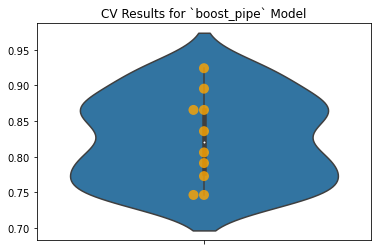

In [35]:
fig, ax = plt.subplots()

boost_pipe.plot_cv(ax=ax);

In [38]:
forest_pipe.print_cv_summary()

CV Results for `forest_pipe` model:
            0.82800 ± 0.06124 accuracy
        


In [37]:
boost_pipe.print_cv_summary()

CV Results for `boost_pipe` model:
            0.82492 ± 0.05907 accuracy
        


## Tuning and Cross-Validating

In [40]:
params = {}
params['rfc__criterion'] = ['gini', 'entropy']
params['rfc__min_samples_leaf'] = [1, 5, 10]

gs = GridSearchCV(estimator=rfc_model_pipe,
                 param_grid=params,
                 cv=10)

In [41]:
gs.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('ct',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('subpipe_num',
                                                                         Pipeline(steps=[('num_impute',
                                                                                          SimpleImputer()),
                                                                                         ('ss',
                                                                                          StandardScaler())]),
                                                                         [2, 3,
                                                                          4,
                                                                          6]),
                                                                        ('subpipe_cat',
                    

In [42]:
gs.best_params_

{'rfc__criterion': 'gini', 'rfc__min_samples_leaf': 1}

In [43]:
# Mean test score for each of six models

gs.cv_results_['mean_test_score']

array([0.82799638, 0.6272275 , 0.62424242, 0.81906377, 0.6272275 ,
       0.62424242])

In [45]:
final_model = gs.best_estimator_

## `imblearn` Pipelines

### Dealing with the Target Imbalance

Let's use `SMOTE()`:

In [46]:
y_train.value_counts()

0    415
1    253
Name: Survived, dtype: int64

In [47]:
sm = SMOTE(sampling_strategy='auto', random_state=42)

In [48]:
sm2 = SMOTE(sampling_strategy=0.8, random_state=42)

To make things simple (and avoid errors!), let's just grab the numeric types and eliminate the NaNs from X_train:

In [49]:
X_train_clean = X_train.select_dtypes(['float', 'int']).dropna()
y_train_clean = y_train[X_train_clean.index]

In [50]:
y_train_clean.value_counts()

0    317
1    219
Name: Survived, dtype: int64

In [51]:
# Even distribution

X_clean_resmp, y_clean_resmp = sm.fit_resample(X_train_clean, y_train_clean)

y_clean_resmp.value_counts()

1    317
0    317
Name: Survived, dtype: int64

In [52]:
# Distribution where count of 1's = 0.8 * count of 0's

X_clean_resmp2, y_clean_resmp2 = sm2.fit_resample(X_train_clean, y_train_clean)

y_clean_resmp2.value_counts()

0    317
1    253
Name: Survived, dtype: int64

### `imblearn` Pipeline

Of course, we want to be able to perform all of our preprocessing steps from above, but just now add `SMOTE`. Good thing we can throw it all into a pipeline!

In [53]:
imb_pipe = ImPipeline(steps=[('ct', CT),
                             ('sm', SMOTE(random_state=42)),
                            ('rfc', RandomForestClassifier(random_state=42))])

In [54]:
imb_pipe.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('subpipe_num',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer()),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  [2, 3, 4, 6]),
                                                 ('subpipe_cat',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                         

In [55]:
imb_pipe.score(X_train, y_train)

0.9985029940119761

### Gridsearching

In [56]:
parameters = {'rfc__criterion': ['gini', 'entropy'],
          'rfc__min_samples_leaf': [1, 5, 10],
          'sm__k_neighbors': [3, 5, 9]}

gs = GridSearchCV(estimator=imb_pipe,
                 param_grid=parameters,
                 cv=10)

In [57]:
gs.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('ct',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('subpipe_num',
                                                                         Pipeline(steps=[('num_impute',
                                                                                          SimpleImputer()),
                                                                                         ('ss',
                                                                                          StandardScaler())]),
                                                                         [2, 3,
                                                                          4,
                                                                          6]),
                                                                        ('subpipe_cat',
                    

In [58]:
gs.best_params_

{'rfc__criterion': 'gini', 'rfc__min_samples_leaf': 1, 'sm__k_neighbors': 5}

In [59]:
gs.best_score_

0.8295115332428764

## Evaluation on Test Set

Let's suppose that we choose our final model from this last GridSearch run. Note that the optimal parameters are also the default values!

In [60]:
imb_pipe

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('subpipe_num',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer()),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  [2, 3, 4, 6]),
                                                 ('subpipe_cat',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                         

In [64]:
final_model = gs.best_estimator_

In [65]:
final_model

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('subpipe_num',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer()),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  [2, 3, 4, 6]),
                                                 ('subpipe_cat',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                         

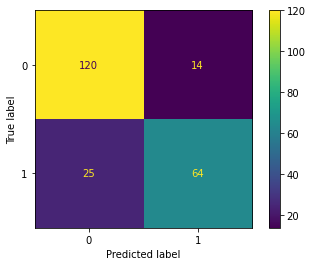

In [66]:
plot_confusion_matrix(final_model, X_test, y_test);

In [67]:
y_hat = final_model.predict(X_test)

In [68]:
print(f"""
Our final model's accuracy on the test set is {round(accuracy_score(y_test, y_hat), 2)}. \n
Our final model's recall on the test set is {round(recall_score(y_test, y_hat), 2)} \n
Our final model's precision on the test set is {round(precision_score(y_test, y_hat), 2)} \n
Our final model's f1-score on the test is {round(f1_score(y_test, y_hat), 2)}.
""")


Our final model's accuracy on the test set is 0.83. 

Our final model's recall on the test set is 0.72 

Our final model's precision on the test set is 0.82 

Our final model's f1-score on the test is 0.77.



In [72]:
final_model['rfc'].feature_importances_

array([8.07253821e-02, 2.37340287e-02, 1.90568738e-02, 7.98922570e-02,
       1.45743765e-02, 1.15358027e-02, 3.18657682e-02, 1.10837137e-01,
       1.20059376e-01, 8.96153785e-04, 2.37748023e-04, 2.74594553e-04,
       5.21359072e-04, 3.23591862e-05, 4.81955370e-04, 5.68859958e-05,
       2.22329457e-03, 3.61602137e-04, 2.01753661e-04, 2.06732900e-04,
       2.39344021e-04, 2.08345155e-04, 4.81414140e-04, 3.02607982e-04,
       2.77436977e-04, 1.26311269e-03, 3.22736483e-04, 1.32976134e-04,
       4.56904830e-04, 3.80118982e-04, 3.21075015e-04, 3.86543245e-04,
       5.02096427e-04, 5.88846836e-04, 2.94011565e-04, 4.69029593e-04,
       2.84160928e-04, 3.57527496e-03, 3.00877716e-04, 4.57157453e-04,
       1.41485954e-03, 1.22639446e-04, 4.05105842e-04, 3.45884822e-04,
       7.31641498e-05, 1.49188989e-04, 3.62681209e-04, 5.68251385e-05,
       2.05535518e-03, 1.30797565e-03, 9.95517689e-05, 2.42158949e-03,
       8.86319713e-04, 2.43228143e-06, 8.57747891e-04, 5.33008358e-04,
      

## Exercise: Your Turn!

Use SMOTE and an estimator (model) of your choice in a pipeline to model the exoplanets' method of discovery ("method"). You can build a model one feature at a time or just throw them all in from the beginning. Consider using the LabelEncoder (from sklearn.preprocessing) to code up the target. You'll also need to make a choice about how to handle the null values.

In [ ]:
exos = sns.load_dataset('planets')

In [ ]:
### Your work here






